Available columns in the data: Index(['Country', 'ID', 'HS Code', 'HS Code description', 'Product', 'Buyer',
       'Buyer's contact', 'Supplier', 'Supplier's contact', 'Arrival date',
       'Total FOB (USD)', 'Total CIF (USD)', 'CIF (USD)', 'FOB (USD)',
       'Unit price (USD)', 'Quantity', 'Country of origin',
       'Gross weight (kg)', 'Etc', 'HSCODE6', 'UNIT', 'PRICE_EURO',
       'INSURANCE', 'ZIPCODE', 'DESTINATION', 'CONTACT1', 'CONTACT2',
       'CONSCONTACT', 'CONSFAX', 'CONSEMAIL', 'CUSTOMAGENT', 'CONSID', 'BANK',
       'DECLARATIONNUMBER', 'Country of origin-원본',
       'Total FOB는 Unit price*quantity 입력값'],
      dtype='object')


c:\Users\hwjh2\miniconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


                                                  Product  Cluster_Label
84960   PRESSURE CONTROL KNOB FOR AA3 PART NO. 648445 ...              5
92555   24\\" MEDICAL HD MONITOR (10448858) (FOR SURGI...              5
166154                       K8AM14F447FF CONTROL MODULE               5
26456   DAZZLESHADOW LIQUID-EVER 4.6GM/.16OZ - (4.60 g...              8
77381      KOCHER FORCEPS 8\\" CURVED (FOR MEDICAL USE) "              5


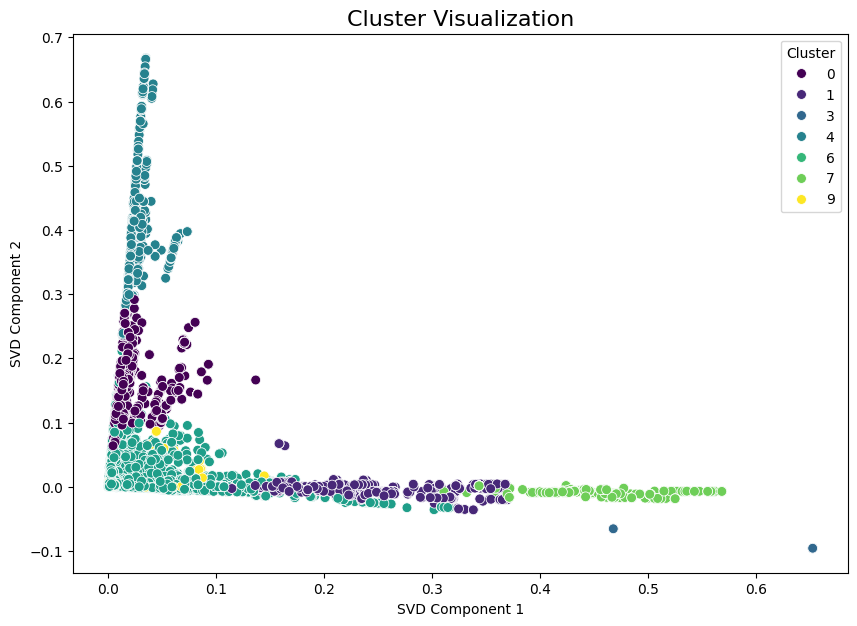

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD  # TruncatedSVD 사용
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 로드
def load_data(filepath):
    # 엑셀 데이터 로드
    data = pd.read_excel(filepath, engine='openpyxl')
    return data

# 2. 랜덤 샘플링
def sample_data(data, sample_size=0.1):  # 샘플링 비율을 10%로 줄임
    # 데이터에서 지정된 비율만큼 랜덤 샘플링
    sample_data = data.sample(frac=sample_size, random_state=42)
    return sample_data

# 3. 텍스트 벡터화 (TF-IDF)
def vectorize_text(data, column):
    # TfidfVectorizer를 사용하여 텍스트 데이터를 벡터화
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(data[column].astype(str))
    return tfidf_matrix

# 4. 클러스터링 수행
def perform_clustering(tfidf_matrix, num_clusters=5):
    # K-means 클러스터링
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(tfidf_matrix)
    return cluster_labels

# 5. 클러스터 시각화 (TruncatedSVD 사용)
def visualize_clusters(tfidf_matrix, cluster_labels):
    # TruncatedSVD로 차원 축소 (PCA 대신 사용)
    svd = TruncatedSVD(n_components=2)  # 2D로 차원 축소
    reduced_embeddings = svd.fit_transform(tfidf_matrix)  # 희소 행렬에서 바로 변환
    
    # 클러스터 시각화
    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        x=reduced_embeddings[:, 0], 
        y=reduced_embeddings[:, 1], 
        hue=cluster_labels, 
        palette='viridis',
        s=50
    )
    plt.title("Cluster Visualization", fontsize=16)
    plt.xlabel("SVD Component 1")
    plt.ylabel("SVD Component 2")
    plt.legend(title="Cluster")
    plt.show()

# 6. 메인 파이프라인
def main():
    # 데이터 경로
    filepath = r"C:\Users\hwjh2\Desktop\딜리버리엠\인도 DB_표준화_210909.xlsx"
    
    # 데이터 로드
    data = load_data(filepath)
    
    # 데이터의 컬럼 이름 확인
    print("Available columns in the data:", data.columns)
    
    # 세분화에 사용할 텍스트 컬럼 설정 (예: 제품 설명)
    product_column = 'Product'  # 데이터에 맞게 컬럼명을 변경하세요.
    
    if product_column not in data.columns:
        raise ValueError(f"Column '{product_column}' not found in the data!")
    
    # 데이터 샘플링 (전체 데이터의 10%만 사용)
    sampled_data = sample_data(data, sample_size=0.1)
    
    # 텍스트 벡터화
    tfidf_matrix = vectorize_text(sampled_data, column=product_column)
    
    # 클러스터링 수행
    num_clusters = 10  # 원하는 클러스터 개수
    cluster_labels = perform_clustering(tfidf_matrix, num_clusters=num_clusters)
    
    # 결과 저장
    sampled_data['Cluster_Label'] = cluster_labels
    print(sampled_data[['Product', 'Cluster_Label']].head())
    
    # 클러스터 시각화
    visualize_clusters(tfidf_matrix, cluster_labels)

# 실행
if __name__ == "__main__":
    main()


In [37]:
import pandas as pd
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.cluster import KMeans
import torch
import numpy as np
from collections import Counter

# DistilBERT 모델과 토크나이저 로드
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertModel.from_pretrained(model_name)

# 데이터 로드
file_path = r"C:\Users\hwjh2\Desktop\딜리버리엠\인도 DB_표준화_210909.xlsx"
data = pd.read_excel(file_path)
products = data['Product'].dropna().tolist()

# 텍스트를 DistilBERT로 임베딩
def embed_text(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)  # 평균 풀링을 사용
    return embeddings.squeeze().numpy()

# 모든 제품명 임베딩
product_embeddings = []
for product in products:
    embedding = embed_text(product)
    product_embeddings.append(embedding)

# NumPy 배열로 변환
product_embeddings = np.array(product_embeddings)

# KMeans 클러스터링
n_clusters = 15  # 원하는 클러스터 개수
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(product_embeddings)

# 각 클러스터의 대표적인 단어 추출
def get_cluster_name(cluster_idx):
    cluster_products = [products[i] for i in range(len(products)) if labels[i] == cluster_idx]
    words = ' '.join(cluster_products).split()
    most_common_words = Counter(words).most_common(3)  # 가장 많이 등장한 3개 단어를 클러스터 이름으로 사용
    cluster_name = ' '.join([word for word, _ in most_common_words])
    return cluster_name

# 클러스터 이름 설정
cluster_names = [get_cluster_name(i) for i in range(n_clusters)]

# 클러스터 레이블을 클러스터 이름으로 변환
data['Cluster Name'] = [cluster_names[label] for label in labels]

# 결과 저장 (product와 cluster name만 포함)
output_path = r"C:\Users\hwjh2\Desktop\clustered_products_with_names.xlsx"
data[['Product', 'Cluster Name']].to_excel(output_path, index=False)
print(f"클러스터링 결과가 저장되었습니다: {output_path}")


KeyboardInterrupt: 